In [1]:
import sys
import os
import pandas as pd

sys.path.append(os.path.abspath("../../ml/"))

from dev_wtp_io_utils import *

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
nonbids_data_path = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/"
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"

In [3]:
#test_train_df_raw = pd.read_csv(nonbids_data_path + "fMRI/ml/train_test_markers_20210601T183243.csv")
#test_train_df_raw = pd.read_csv(nonbids_data_path + "fMRI/ml/train_test_markers_20211027T173724.csv")
test_train_df_raw = pd.read_csv(nonbids_data_path + "fMRI/ml/train_test_markers_20220818T144138.csv")


In [4]:
include_exclude_list = pd.read_csv("../nsc_subject_exclusions.csv")

In [5]:
test_train_df_raw = test_train_df_raw.merge(include_exclude_list[include_exclude_list.Task=='SST'],left_on='sub_label',right_on='SubjectId',how='left')
test_train_df_raw.loc[test_train_df_raw.Include.isna(),'Include'] = True
test_train_df = test_train_df_raw[test_train_df_raw.Include==True]

In [6]:
exclude_subjects = ['DEV061','DEV185','DEV187','DEV189','DEV190','DEV192','DEV198','DEV203','DEV220','DEV221']
#2022-01-06 added DEV157 because of an error

In [7]:
train_subjs = test_train_df.loc[test_train_df.SplitGroup=='Train','sub_label'].tolist()#only get the train subjects; ignore those previously marked hold-out

In [8]:
test_train_df

,sub_label,SplitGroup,Assigned,SplitGroup_75_25,SubjectId,Task,Include
1,DEV004,Holdout,June,Holdout,NaN,NaN,True
2,DEV005,Train,June,Train,NaN,NaN,True
3,DEV006,Train,June,Train,NaN,NaN,True
4,DEV007,Holdout,October2021,Train,NaN,NaN,True
5,DEV008,Holdout,June,Holdout,NaN,NaN,True
...,...,...,...,...,...,...,...
242,DEV285,Holdout,August2022,Holdout,NaN,NaN,True
243,DEV286,Holdout,August2022,Train,NaN,NaN,True
244,DEV290,Train,August2022,Train,NaN,NaN,True
245,DEV291,Train,August2022,Train,NaN,NaN,True


In [9]:
def get_Brain_Data_for_sub(sub_label,behavdesign,betaseries_path='/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/betaseries/'):
    return(dev_wtp_io_utils.get_Brain_Data_betas_for_sub(sub_label,behavdesign,betaseries_path))

In [10]:
from dev_wtp_io_utils import import_sst_betaseries_w1_subjs_to_pkl

In [11]:
all_sst_events= pd.read_csv(ml_data_folderpath +"/SST/" + "all_sst_events.csv")
#cut out other waves
sst_1_behavdesign_1 = all_sst_events[(all_sst_events.wave=='wave1')].reset_index(drop=True)
#label the ITI as such
sst_1_behavdesign_1.loc[(all_sst_events.trial_type.isna()),'trial_type']='ITI'
#ensure it is correctly ordered
sst_1_behavdesign_clean = sst_1_behavdesign_1.sort_values(['subject','onset']).reset_index(drop=True)
#now tell it the name of the corresponding beta. this is easy; they are all consecutive
sst_1_behavdesign_clean['beta'] = 'beta_' + (sst_1_behavdesign_clean.groupby(['subject','wave']).cumcount()+1).astype(str).apply(lambda x: x.zfill(4)) + '.nii'

In [12]:
sst_1_behavdesign_clean

,onset,duration,trial_type,subject,wave,beta
0,0.00000,0.63061,correct-go,DEV004,wave1,beta_0001.nii
1,2.25834,0.75000,ITI,DEV004,wave1,beta_0002.nii
2,3.00834,2.00556,failed-stop,DEV004,wave1,beta_0003.nii
3,5.01390,1.37500,ITI,DEV004,wave1,beta_0004.nii
4,6.38890,0.43276,correct-go,DEV004,wave1,beta_0005.nii
...,...,...,...,...,...,...
52219,412.82572,1.75000,ITI,DEV225,wave1,beta_0252.nii
52220,414.57572,0.50949,correct-go,DEV225,wave1,beta_0253.nii
52221,417.08682,0.75000,ITI,DEV225,wave1,beta_0254.nii
52222,417.83682,1.50000,failed-stop,DEV225,wave1,beta_0255.nii


In [13]:
#I want to import this other module; we don't actually use it but it's a good reference
#for future programmers to see
#it's important we keep the logic consistent for the two main conditions
sys.path.append(os.path.abspath("../../fx/multiconds/SST/"))
from multiconds import create_posterror_masks_from_masks

#sst_1_behavdesign_clean['prev_trial_type'] = sst_1_behavdesign_clean['trial_type']
sst_1_behavdesign_clean['prev_trial_type'] = (
    sst_1_behavdesign_clean
    .loc[sst_1_behavdesign_clean['trial_type']!='ITI']
    .groupby(['subject','wave'])
    .shift(1)
    ['trial_type']
)#this works because during assignment, items will be assigned to the line corresponding to their index
#very important you don't reset index during this operation.
is_post_stop_correct_go = (
    (sst_1_behavdesign_clean['trial_type']=='correct-go') & 
    (sst_1_behavdesign_clean['prev_trial_type'].isin(['failed-stop','correct-stop']))
)

sst_1_behavdesign_clean.loc[is_post_stop_correct_go,'post_stop_correct_go_subtype'] = 'Other'
sst_1_behavdesign_clean.loc[is_post_stop_correct_go & (sst_1_behavdesign_clean['prev_trial_type']=='failed-stop'),'post_stop_correct_go_subtype'] = 'post-error'
sst_1_behavdesign_clean.loc[is_post_stop_correct_go & (sst_1_behavdesign_clean['prev_trial_type']=='correct-stop'),'post_stop_correct_go_subtype'] = 'post-correct'


In [14]:
sst_1_behavdesign_clean[0:30]

,onset,duration,trial_type,subject,wave,beta,prev_trial_type,post_stop_correct_go_subtype
0,0.00000,0.63061,correct-go,DEV004,wave1,beta_0001.nii,NaN,NaN
1,2.25834,0.75000,ITI,DEV004,wave1,beta_0002.nii,NaN,NaN
2,3.00834,2.00556,failed-stop,DEV004,wave1,beta_0003.nii,correct-go,NaN
3,5.01390,1.37500,ITI,DEV004,wave1,beta_0004.nii,NaN,NaN
4,6.38890,0.43276,correct-go,DEV004,wave1,beta_0005.nii,failed-stop,post-error
5,8.64724,3.12500,ITI,DEV004,wave1,beta_0006.nii,NaN,NaN
6,11.77224,2.00556,failed-stop,DEV004,wave1,beta_0007.nii,correct-go,NaN
7,13.77780,1.87500,ITI,DEV004,wave1,beta_0008.nii,NaN,NaN
8,15.65280,0.69477,correct-go,DEV004,wave1,beta_0009.nii,failed-stop,post-error
9,17.78475,2.75000,ITI,DEV004,wave1,beta_0010.nii,NaN,NaN


In [15]:
sst_1_behavdesign_clean.groupby(['trial_type','post_stop_correct_go_subtype']).size().reset_index()

,trial_type,post_stop_correct_go_subtype,0
0,correct-go,post-correct,1879
1,correct-go,post-error,2145


In [16]:
sst_1_behavdesign_clean.post_stop_correct_go_subtype.value_counts()

post-error      2145
post-correct    1879
Name: post_stop_correct_go_subtype, dtype: int64

In [17]:
sst_1_behavdesign_clean['trial_type'].value_counts()

ITI             26112
correct-go      18750
failed-stop      3434
correct-stop     3094
failed-go         834
Name: trial_type, dtype: int64

In [18]:
behavdesign = sst_1_behavdesign_clean
sst_1_behavdesign_clean_dev005 = behavdesign[[s in 'DEV005' for s in behavdesign.subject]]

In [19]:
sst_1_behavdesign_clean_dev005.groupby('trial_type').count()

,onset,duration,subject,wave,beta,prev_trial_type,post_stop_correct_go_subtype
trial_type,,,,,,,
ITI,128,128,128,128,128,0,0
correct-go,80,80,80,80,80,80,18
correct-stop,5,5,5,5,5,4,0
failed-go,16,16,16,16,16,16,0
failed-stop,27,27,27,27,27,27,0


## Continued...

In [20]:
import_sst_betaseries_w1_subjs_to_pkl(
    train_subjs[0:2],'betaseries',
    behavioral_design=sst_1_behavdesign_clean,
    out_folder = ml_data_folderpath + "/")

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/betaseries/
DEV005
...................................................................................................................................................................................................................................................................verified that all expected betas exist! Processing...setting the mask to the first image in the series beta_0001.nii
temp mask created.
loading files. This step may take some time...
converting to nifti and fdata
         onset  duration    trial_type subject   wave           beta  \
256    0.00000   2.25834  correct-stop  DEV005  wave1  beta_0001.nii   
257    2.25834   0.50000           ITI  DEV005  wave1  beta_0002.nii   
258    2.75834   0.40082    correct-go  DEV005  wave1  beta_0003.nii   
259    4.76390   0.75000           ITI  DEV005  wave1  beta_0004.nii   
260    5.51390   0.66191    correct-go  DEV005  wave1  beta_0005.nii   
..    

OK, not bad, so we have learned to load data, and show it. We might be best to re-write the code, though, to use the first image as the image series's own mask--using `nilearn.masking.compute_brain_mask`, rather than worry about why the input mask isn't quite aligned. 

In [89]:
len(train_subjs)

59

In [94]:
import_sst_betaseries_w1_subjs_to_pkl(
     train_subjs[0:6],'betaseries',
    behavioral_design=sst_1_behavdesign_clean,
    out_folder = ml_data_folderpath + "/SST/")

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/betaseries/
DEV005
...................................................................................................................................................................................................................................................................verified that all expected betas exist! Processing...setting the mask to the first image in the series beta_0001.nii
During mask creation, received error 'Resampling binary images with continuous or linear interpolation.'. This is normal.
temp mask created.
loading files. This step may take some time...
...imported data.
temp mask deleted
DEV006
...................................................................................................................................................................................................................................................................verified that all expected betas exist! Proc

In [16]:
import_sst_betaseries_w1_subjs_to_pkl(
    train_subjs[0:40],'betaseries',
    behavioral_design=sst_1_behavdesign_clean,
    out_folder = ml_data_folderpath + "/SST/")

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/betaseries/
DEV005
...................................................................................................................................................................................................................................................................verified that all expected betas exist! Processing...setting the mask to the first image in the series beta_0001.nii
During mask creation, received error 'Resampling binary images with continuous or linear interpolation.'. This is normal.
temp mask created.
loading files. This step may take some time...
...imported data.
temp mask deleted
DEV006
...................................................................................................................................................................................................................................................................verified that all expected betas exist! Proc

In [ ]:
import_sst_betaseries_w1_subjs_to_pkl(
    train_subjs[0:40],'betaseries',
    behavioral_design=sst_1_behavdesign_clean,
    out_folder = ml_data_folderpath + "/SST/")

## Just subjects in the conditions of interest: CorrectStop vs. CorrectGo

In [22]:
sst_1_behavdesign_clean.trial_type.value_counts()

ITI             26112
correct-go      18750
failed-stop      3434
correct-stop     3094
failed-go         834
Name: trial_type, dtype: int64

In [23]:
sst_1_behavdesign_correct_conditions=sst_1_behavdesign_clean[sst_1_behavdesign_clean.trial_type.isin(['correct-go','correct-stop'])]

In [24]:
sst_1_behavdesign_correct_conditions.trial_type.value_counts()

correct-go      18750
correct-stop     3094
Name: trial_type, dtype: int64

In [25]:
sst_1_behavdesign_correct_conditions

,onset,duration,trial_type,subject,wave,beta,prev_trial_type,post_stop_correct_go_subtype
0,0.00000,0.63061,correct-go,DEV004,wave1,beta_0001.nii,NaN,NaN
4,6.38890,0.43276,correct-go,DEV004,wave1,beta_0005.nii,failed-stop,post-error
8,15.65280,0.69477,correct-go,DEV004,wave1,beta_0009.nii,failed-stop,post-error
10,20.53475,0.85534,correct-go,DEV004,wave1,beta_0011.nii,correct-go,NaN
12,23.35212,0.48997,correct-go,DEV004,wave1,beta_0013.nii,correct-go,NaN
...,...,...,...,...,...,...,...,...
52210,398.86111,0.51663,correct-go,DEV225,wave1,beta_0243.nii,correct-go,NaN
52214,403.99723,0.72046,correct-go,DEV225,wave1,beta_0247.nii,failed-stop,post-error
52216,407.31460,0.62814,correct-go,DEV225,wave1,beta_0249.nii,correct-go,NaN
52218,410.82016,0.51824,correct-go,DEV225,wave1,beta_0251.nii,correct-go,NaN


In [26]:
import_sst_betaseries_w1_subjs_to_pkl(
    train_subjs[0:5],'betaseries',
    behavioral_design=sst_1_behavdesign_correct_conditions,
    out_folder = ml_data_folderpath + "/SST/",
out_file_suffix = '_correct_cond')

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/betaseries/
DEV005
........................................................................................verified that all expected betas exist! Processing...retrieving a mask from the first image in the series beta_0001.nii
temp mask created.
loading files. This step may take some time...
converting to nifti and fdata
         onset  duration    trial_type subject   wave           beta  \
256    0.00000   2.25834  correct-stop  DEV005  wave1  beta_0001.nii   
258    2.75834   0.40082    correct-go  DEV005  wave1  beta_0003.nii   
260    5.51390   0.66191    correct-go  DEV005  wave1  beta_0005.nii   
264   12.52780   0.51712    correct-go  DEV005  wave1  beta_0009.nii   
266   15.90975   0.39906    correct-go  DEV005  wave1  beta_0011.nii   
..         ...       ...           ...     ...    ...            ...   
498  398.86111   0.49379    correct-go  DEV005  wave1  beta_0243.nii   
502  403.99723   0.47630    co

3
4
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/Brain_Data_betaseries_5subs_correct_cond.pkl


In [31]:
import_sst_betaseries_w1_subjs_to_pkl(
    train_subjs[0:40],'betaseries',
    behavioral_design=sst_1_behavdesign_correct_conditions,
    out_folder = ml_data_folderpath + "/SST/",
out_file_suffix = '_correct_cond')

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/betaseries/
DEV005
........................................................................................verified that all expected betas exist! Processing...setting the mask to the first image in the series beta_0001.nii
During mask creation, received error 'Resampling binary images with continuous or linear interpolation.'. This is normal.
temp mask created.
loading files. This step may take some time...
...imported data.
temp mask deleted
DEV006
.................................................................................................................verified that all expected betas exist! Processing...setting the mask to the first image in the series beta_0009.nii
During mask creation, received error 'Resampling binary images with continuous or linear interpolation.'. This is normal.
temp mask created.
loading files. This step may take some time...
...imported data.
temp mask deleted
DEV009
.............

In [19]:
import_sst_betaseries_w1_subjs_to_pkl(
    train_subjs[0:15],'betaseries',
    behavioral_design=sst_1_behavdesign_correct_conditions,
    out_folder = ml_data_folderpath + "/SST/",
out_file_suffix = '_correct_cond')

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/betaseries/
DEV005
........................................................................................verified that all expected betas exist! Processing...setting the mask to the first image in the series beta_0001.nii
During mask creation, received error 'Resampling binary images with continuous or linear interpolation.'. This is normal.
temp mask created.
loading files. This step may take some time...
...imported data.
temp mask deleted
DEV006
.................................................................................................................verified that all expected betas exist! Processing...setting the mask to the first image in the series beta_0009.nii
During mask creation, received error 'Resampling binary images with continuous or linear interpolation.'. This is normal.
temp mask created.
loading files. This step may take some time...
...imported data.
temp mask deleted
DEV009
.............

In [22]:
#we have data missing fro mthese subjects below. not enstirely sure yet; see 
#https://docs.google.com/document/d/1EB0ACA6qhMkDEgv-zqNTepPCe_x41fRQHaeqT47vazM/edit#heading=h.60rb13rlxkrq


train_subjs_selected = [ts for ts in train_subjs if (ts not in exclude_subjects)]

In [23]:
sst_1_behavdesign_correct_conditions[sst_1_behavdesign_correct_conditions.subject=='DEV157']

NameError: name 'sst_1_behavdesign_correct_conditions' is not defined

In [52]:
sst_1_behavdesign_correct_conditions[sst_1_behavdesign_correct_conditions.subject=='DEV005']

,onset,duration,trial_type,subject,wave,beta
256,0.00000,2.25834,correct-stop,DEV005,wave1,beta_0001.nii
258,2.75834,0.40082,correct-go,DEV005,wave1,beta_0003.nii
260,5.51390,0.66191,correct-go,DEV005,wave1,beta_0005.nii
264,12.52780,0.51712,correct-go,DEV005,wave1,beta_0009.nii
266,15.90975,0.39906,correct-go,DEV005,wave1,beta_0011.nii
...,...,...,...,...,...,...
498,398.86111,0.49379,correct-go,DEV005,wave1,beta_0243.nii
502,403.99723,0.47630,correct-go,DEV005,wave1,beta_0247.nii
504,407.31460,0.48262,correct-go,DEV005,wave1,beta_0249.nii
506,410.82016,0.40118,correct-go,DEV005,wave1,beta_0251.nii


In [53]:
sst_1_behavdesign_correct_conditions[sst_1_behavdesign_correct_conditions.subject=='DEV007']

,onset,duration,trial_type,subject,wave,beta
768,0.00000,0.61188,correct-go,DEV007,wave1,beta_0001.nii
772,6.38890,0.47920,correct-go,DEV007,wave1,beta_0005.nii
776,15.65280,0.46264,correct-go,DEV007,wave1,beta_0009.nii
778,20.53475,0.42175,correct-go,DEV007,wave1,beta_0011.nii
780,23.35212,0.43000,correct-go,DEV007,wave1,beta_0013.nii
...,...,...,...,...,...,...
1014,407.24723,0.59047,correct-go,DEV007,wave1,beta_0247.nii
1016,409.68960,2.00556,correct-stop,DEV007,wave1,beta_0249.nii
1018,412.44516,0.62645,correct-go,DEV007,wave1,beta_0251.nii
1020,416.20072,2.51110,correct-stop,DEV007,wave1,beta_0253.nii


In [63]:
# def get_Brain_Data_for_sub(sub_label,behavdesign,betaseries_path='/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/betaseries/'):
#     return(dev_wtp_io_utils.get_Brain_Data_betas_for_sub(sub_label,behavdesign,betaseries_path))
import dev_wtp_io_utils
sl = 'DEV085'
bd=sst_1_behavdesign_correct_conditions
first_level_path = '/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/betaseries/'
get_Brain_Data_betas_for_sub(
                sl, bd,
                betaseries_path = first_level_path,
                events_in_design=bd[bd.subject==sl].shape[0],
                mask = "beta" # '/projects/sanlab/shared/spm12/canonical/MNI152_T1_1mm_brain_mask.nii'
            )


.................................................................................................................verified that all expected betas exist! Processing...setting the mask to the first image in the series beta_0005.nii
During mask creation, received error 'Resampling binary images with continuous or linear interpolation.'. This is normal.
temp mask created.
loading files. This step may take some time...
...imported data.
temp mask deleted


nltools.data.brain_data.Brain_Data(data=(110, 229019), Y=0, X=(110, 6), mask=temp_mask_get_Brain_Data_betas_for_sub_DEV085.nii, output_file=[])

In [66]:
# def get_Brain_Data_for_sub(sub_label,behavdesign,betaseries_path='/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/betaseries/'):
#     return(dev_wtp_io_utils.get_Brain_Data_betas_for_sub(sub_label,behavdesign,betaseries_path))
import dev_wtp_io_utils
sl = 'DEV157'
bd=sst_1_behavdesign_correct_conditions
first_level_path = '/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/betaseries/'
get_Brain_Data_betas_for_sub(
                sl, bd,
                betaseries_path = first_level_path,
                events_in_design=bd[bd.subject==sl].shape[0],
                mask = "beta" # '/projects/sanlab/shared/spm12/canonical/MNI152_T1_1mm_brain_mask.nii'
            )


............................................................................................................verified that all expected betas exist! Processing...setting the mask to the first image in the series beta_0001.nii
During mask creation, received error 'Resampling binary images with continuous or linear interpolation.'. This is normal.
temp mask created.
loading files. This step may take some time...


KeyboardInterrupt: 

In [65]:
np.unique(sst_1_behavdesign_correct_conditions.subject)

array(['DEV004', 'DEV005', 'DEV006', 'DEV007', 'DEV008', 'DEV009',
       'DEV010', 'DEV011', 'DEV012', 'DEV013', 'DEV014', 'DEV015',
       'DEV016', 'DEV017', 'DEV018', 'DEV019', 'DEV020', 'DEV021',
       'DEV022', 'DEV023', 'DEV024', 'DEV025', 'DEV026', 'DEV027',
       'DEV028', 'DEV029', 'DEV030', 'DEV031', 'DEV032', 'DEV033',
       'DEV034', 'DEV035', 'DEV036', 'DEV037', 'DEV038', 'DEV039',
       'DEV040', 'DEV041', 'DEV042', 'DEV043', 'DEV044', 'DEV045',
       'DEV046', 'DEV047', 'DEV048', 'DEV049', 'DEV050', 'DEV051',
       'DEV052', 'DEV053', 'DEV054', 'DEV055', 'DEV056', 'DEV057',
       'DEV058', 'DEV059', 'DEV060', 'DEV062', 'DEV063', 'DEV064',
       'DEV065', 'DEV066', 'DEV067', 'DEV068', 'DEV069', 'DEV070',
       'DEV071', 'DEV072', 'DEV073', 'DEV074', 'DEV075', 'DEV076',
       'DEV077', 'DEV078', 'DEV079', 'DEV080', 'DEV081', 'DEV082',
       'DEV083', 'DEV084', 'DEV085', 'DEV086', 'DEV087', 'DEV088',
       'DEV089', 'DEV090', 'DEV091', 'DEV093', 'DEV094', 'DEV0

In [ ]:
import_sst_betaseries_w1_subjs_to_pkl(
    train_subjs_selected,'betaseries',
    behavioral_design=sst_1_behavdesign_correct_conditions,
    out_folder = ml_data_folderpath + "/SST/",
out_file_suffix = '_correct_cond')

### Now mask those subjects

In [20]:
# get the PFC mask
mask_pfc = nib.load(ml_data_folderpath + '/prefrontal_cortex.nii.gz')

In [27]:
import_sst_betaseries_w1_subjs_to_pkl(
    train_subjs[0:2],'betaseries',
    behavioral_design=sst_1_behavdesign_correct_conditions,
    out_folder = ml_data_folderpath + "/SST/",
    mask = mask_pfc,
    out_file_suffix = '_correct_cond')

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/betaseries/
DEV005
........................................................................................verified that all expected betas exist! Processing...retrieving a mask from the first image in the series beta_0001.nii
During mask creation, received error 'Resampling binary images with continuous or linear interpolation.'. This is normal.
temp mask created.
loading files. This step may take some time...
converting to nifti and fdata
         onset  duration    trial_type subject   wave           beta  \
256    0.00000   2.25834  correct-stop  DEV005  wave1  beta_0001.nii   
258    2.75834   0.40082    correct-go  DEV005  wave1  beta_0003.nii   
260    5.51390   0.66191    correct-go  DEV005  wave1  beta_0005.nii   
264   12.52780   0.51712    correct-go  DEV005  wave1  beta_0009.nii   
266   15.90975   0.39906    correct-go  DEV005  wave1  beta_0011.nii   
..         ...       ...           ...     ...    ..

In [58]:
# first_img_path = (
# '/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/betaseries/sub-' 
#     + train_subjs[0] + "/beta_0001.nii")
first_img = nil.image.load_img(first_img_path)
mask_test = nil.masking.compute_brain_mask(first_img,threshold=0)

mask_resampled = nl.image.resample_to_img(mask_pfc, first_img)
mask_resampled_bin = nl.image.math_img("img>0.5",img=mask_resampled)
nl.plotting.plot_roi(mask_resampled_bin)
combined_mask = nl.masking.intersect_masks([mask_test,mask_resampled_bin])
nl.plotting.plot_roi(combined_mask)

In [29]:
import_sst_betaseries_w1_subjs_to_pkl(
    train_subjs[0:2],'betaseries',
    behavioral_design=sst_1_behavdesign_correct_conditions,
    out_folder = ml_data_folderpath + "/SST/",
    mask = mask_pfc,
    mask_threshold=0,
    out_file_suffix = '_correct_cond')

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/betaseries/
DEV005
........................................................................................verified that all expected betas exist! Processing...retrieving a mask from the first image in the series beta_0001.nii
During mask creation, received error 'Resampling binary images with continuous or linear interpolation.'. This is normal.
temp mask created.
loading files. This step may take some time...
converting to nifti and fdata
         onset  duration    trial_type subject   wave           beta  \
256    0.00000   2.25834  correct-stop  DEV005  wave1  beta_0001.nii   
258    2.75834   0.40082    correct-go  DEV005  wave1  beta_0003.nii   
260    5.51390   0.66191    correct-go  DEV005  wave1  beta_0005.nii   
264   12.52780   0.51712    correct-go  DEV005  wave1  beta_0009.nii   
266   15.90975   0.39906    correct-go  DEV005  wave1  beta_0011.nii   
..         ...       ...           ...     ...    ..

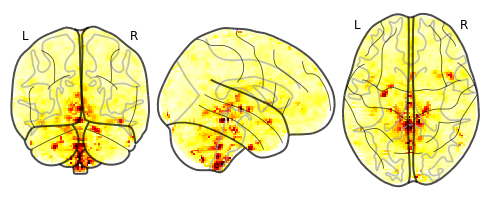

In [45]:
result = pickle.load(open("/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/Brain_Data_betaseries_2subs_correct_cond.pkl", "rb"))

from nilearn.plotting import plot_glass_brain

plot_glass_brain(result[0].to_nifti())

## just post-stop correct-go subjects

0        False
1        False
2        False
3        False
4         True
         ...  
52219    False
52220    False
52221    False
52222    False
52223    False
Name: post_stop_correct_go_subtype, Length: 52224, dtype: bool

In [26]:
sst_1_behavdesign_pscg=sst_1_behavdesign_clean[pd.isna(sst_1_behavdesign_clean.post_stop_correct_go_subtype)==False]

In [27]:
sst_1_behavdesign_pscg

,onset,duration,trial_type,subject,wave,beta,prev_trial_type,post_stop_correct_go_subtype
4,6.38890,0.43276,correct-go,DEV004,wave1,beta_0005.nii,failed-stop,post-error
8,15.65280,0.69477,correct-go,DEV004,wave1,beta_0009.nii,failed-stop,post-error
28,46.39384,0.63064,correct-go,DEV004,wave1,beta_0029.nii,failed-stop,post-error
32,54.71955,0.67312,correct-go,DEV004,wave1,beta_0033.nii,failed-stop,post-error
36,62.10429,0.47536,correct-go,DEV004,wave1,beta_0037.nii,correct-stop,post-correct
...,...,...,...,...,...,...,...,...
52160,314.15890,0.54870,correct-go,DEV225,wave1,beta_0193.nii,correct-stop,post-correct
52164,322.04917,0.51455,correct-go,DEV225,wave1,beta_0197.nii,failed-stop,post-error
52180,349.90546,0.66473,correct-go,DEV225,wave1,beta_0213.nii,failed-stop,post-error
52200,381.58192,0.50186,correct-go,DEV225,wave1,beta_0233.nii,correct-stop,post-correct


In [28]:
import_sst_betaseries_w1_subjs_to_pkl(
    train_subjs[0:5],'betaseries',
    behavioral_design=sst_1_behavdesign_pscg,
    out_folder = ml_data_folderpath + "/SST/",
out_file_suffix = '_poststop_correctgo')

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/betaseries/
DEV005
.....................verified that all expected betas exist! Processing...setting the mask to the first image in the series beta_0003.nii
During mask creation, received error 'Resampling binary images with continuous or linear interpolation.'. This is normal.
temp mask created.
loading files. This step may take some time...
...imported data.
temp mask deleted
DEV006
.......................verified that all expected betas exist! Processing...setting the mask to the first image in the series beta_0009.nii
During mask creation, received error 'Resampling binary images with continuous or linear interpolation.'. This is normal.
temp mask created.
loading files. This step may take some time...
...imported data.
temp mask deleted
DEV009
.........................verified that all expected betas exist! Processing...setting the mask to the first image in the series beta_0005.nii
During mask creation, receiv

In [44]:
#we have data missing fro mthese subjects below. not enstirely sure yet; see 
#https://docs.google.com/document/d/1EB0ACA6qhMkDEgv-zqNTepPCe_x41fRQHaeqT47vazM/edit#heading=h.60rb13rlxkrq


train_subjs_selected = [ts for ts in train_subjs if (ts not in exclude_subjects)]

In [45]:
len(train_subjs_selected)

84

In [46]:
import_sst_betaseries_w1_subjs_to_pkl(
    train_subjs_selected,'betaseries',
    behavioral_design=sst_1_behavdesign_pscg,
    out_folder = ml_data_folderpath + "/SST/",
out_file_suffix = '_poststop_correctgo')

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/betaseries/
DEV005
.....................verified that all expected betas exist! Processing...setting the mask to the first image in the series beta_0003.nii
During mask creation, received error 'Resampling binary images with continuous or linear interpolation.'. This is normal.
temp mask created.
loading files. This step may take some time...
...imported data.
temp mask deleted
DEV006
.......................verified that all expected betas exist! Processing...setting the mask to the first image in the series beta_0009.nii
During mask creation, received error 'Resampling binary images with continuous or linear interpolation.'. This is normal.
temp mask created.
loading files. This step may take some time...
...imported data.
temp mask deleted
DEV009
.........................verified that all expected betas exist! Processing...setting the mask to the first image in the series beta_0005.nii
During mask creation, receiv

...imported data.
temp mask deleted
DEV029
.........................verified that all expected betas exist! Processing...setting the mask to the first image in the series beta_0005.nii
During mask creation, received error 'Resampling binary images with continuous or linear interpolation.'. This is normal.
temp mask created.
loading files. This step may take some time...
...imported data.
temp mask deleted
DEV030
.......................verified that all expected betas exist! Processing...setting the mask to the first image in the series beta_0003.nii
During mask creation, received error 'Resampling binary images with continuous or linear interpolation.'. This is normal.
temp mask created.
loading files. This step may take some time...
...imported data.
temp mask deleted
DEV034
.........................verified that all expected betas exist! Processing...setting the mask to the first image in the series beta_0005.nii
During mask creation, received error 'Resampling binary images with con

.........................verified that all expected betas exist! Processing...setting the mask to the first image in the series beta_0005.nii
During mask creation, received error 'Resampling binary images with continuous or linear interpolation.'. This is normal.
temp mask created.
loading files. This step may take some time...
...imported data.
temp mask deleted
DEV060
.......................verified that all expected betas exist! Processing...setting the mask to the first image in the series beta_0003.nii
During mask creation, received error 'Resampling binary images with continuous or linear interpolation.'. This is normal.
temp mask created.
loading files. This step may take some time...
...imported data.
temp mask deleted
DEV062
.........................verified that all expected betas exist! Processing...setting the mask to the first image in the series beta_0005.nii
During mask creation, received error 'Resampling binary images with continuous or linear interpolation.'. This is 